In [ ]:
import numpy as np
from src.Normalizer import normalize_file
from src.Tokenizer import  Tokenizer
from src.NgramModel import NGModel
import matplotlib.pyplot as plt
import seaborn as sns

## Language Modelling

In [ ]:
af_file = "data/train.af.txt"
en_file = "data/train.en.txt"
nl_file = "data/train.nl.txt"
xh_file = "data/train.xh.txt"
zu_file = "data/train.zu.txt"

af_val_file = "data/val.af.txt"
en_val_file = "data/val.en.txt"
nl_val_file = "data/val.nl.txt"
xh_val_file = "data/val.xh.txt"
zu_val_file = "data/val.zu.txt"

norm_af_file = "data/normalized.af.txt"
norm_en_file = "data/normalized.en.txt"
norm_nl_file = "data/normalized.nl.txt"
norm_xh_file = "data/normalized.xh.txt"
norm_zu_file = "data/normalized.zu.txt"

# normalize_file(af_file, norm_af_file)
# normalize_file(en_file, norm_en_file)
# normalize_file(nl_file, norm_nl_file)
# normalize_file(xh_file, norm_xh_file)
# normalize_file(zu_file, norm_zu_file)

In [ ]:
af_model = NGModel("af", 3, Tokenizer())
en_model = NGModel("en", 3, Tokenizer())
nl_model = NGModel("nl", 3, Tokenizer())
xh_model = NGModel("xh", 3, Tokenizer())
zu_model = NGModel("zu", 3, Tokenizer())
af_model.train(norm_af_file)
en_model.train(norm_en_file)
nl_model.train(norm_nl_file)
xh_model.train(norm_xh_file)
zu_model.train(norm_zu_file)

Training af model... DONE!
Training en model... DONE!
Training nl model... DONE!
Training xh model... DONE!
Training zu model... DONE!


In [ ]:
models = (af_model, en_model, nl_model, xh_model, zu_model)
val_files = (af_val_file, en_val_file, nl_val_file, xh_val_file, zu_val_file)

In [ ]:
alphas = np.linspace(1e-1, 1, 10)
en_pps = tune_alpha(en_model, en_val_file, alphas)

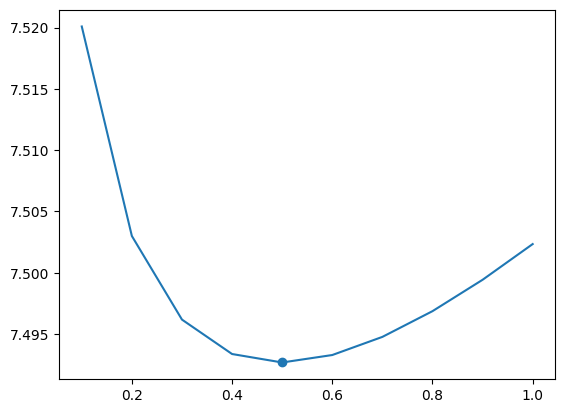

In [ ]:
k = np.argmin(en_pps)
plt.plot(alphas, en_pps)
plt.scatter(alphas[k], en_pps[k])
plt.show()

## Perplexity and hyper-parameter tunning

In [ ]:
def evalModels(models, files):
    sums = np.zeros(len(models))
    counts = np.zeros(len(models))
    with open(files) as corpus:
        for line in corpus:
            for i, model in enumerate(models):
                p, c = model.perplexity(line, doc=True)
                sums[i] += p
                counts[i] += c
    _h = -sums / counts
    docPP = np.exp(_h)
    return docPP


def tune_alpha(model, val_file, alphas):
    perplexities = []
    for alpha in alphas:
        sums, counts = 0, 0
        with open(val_file) as corpus:
            for line in corpus:
                p, c = model.perplexity(line, alpha=alpha, doc=True)
                sums += p 
                counts += c
        perplexities.append(np.exp(-sums/counts))
    return perplexities

4

In [ ]:
models = (af_model, en_model, nl_model, xh_model, zu_model)
val_files = (af_val_file, en_val_file, nl_val_file, xh_val_file, zu_val_file)

In [ ]:
PPS = np.array([])
for val_file in val_files:
    PPS= np.append(PPS, evalModels(models, val_file))
PP = PP.reshape(5,5)
labels = categories=[model.name for model in models]
plt.figure(figsize=(6, 5))
sns.heatmap(PP, annot=True)
plt.xticks(np.arange(len(labels))+0.5,labels)
plt.yticks(np.arange(len(labels))+0.5,labels)
plt.title("Perplexity")
plt.show()

NameError: name 'np' is not defined

In [ ]:
import numpy as np

def evalModel(models, file, alpha=1):
    """
    Evaluate models on a validation file using the specified alpha for add-K smoothing.
    
    Args:
        models (tuple): A tuple of NGModel instances.
        file (str): Path to the validation file.
        alpha (float): The smoothing parameter.
    
    Returns:
        np.ndarray: Document perplexity for each model.
    """
    sums = np.zeros(len(models))
    counts = np.zeros(len(models))
    with open(file) as corpus:
        for line in corpus:
            for i, model in enumerate(models):
                p, c = model.addKLogProb(line, alpha=alpha)
                sums[i] += p
                counts[i] += c
    _h = -sums / counts
    docPP = np.exp(_h)
    return docPP

def tune_alpha(models, val_files, alphas):
    """
    Tune the alpha parameter for each model using validation datasets.
    
    Args:
        models (tuple): A tuple of NGModel instances.
        val_files (tuple): A tuple of validation file paths corresponding to the models.
        alphas (list): A list of alpha values to test.
    
    Returns:
        list: The optimal alpha values for each model.
    """
    optimal_alphas = []
    for i, (model, val_file) in enumerate(zip(models, val_files)):
        best_alpha = None
        best_perplexity = float('inf')
        for alpha in alphas:
            perplexity = evalModel([model], val_file, alpha=alpha)[0]
            if perplexity < best_perplexity:
                best_perplexity = perplexity
                best_alpha = alpha
        optimal_alphas.append(best_alpha)
    return optimal_alphas

def detect_language(models, sentence, optimal_alphas):
    """
    Detect the language of a given sentence using the models with the optimal alpha values.
    
    Args:
        models (tuple): A tuple of NGModel instances.
        sentence (str): The input sentence to detect the language of.
        optimal_alphas (list): The optimal alpha values for each model.
    
    Returns:
        str: The name of the detected language model.
    """
    perplexities = []
    for model, alpha in zip(models, optimal_alphas):
        perplexity, _ = model.addKLogProb(sentence, alpha=alpha)
        perplexities.append(np.exp(-perplexity))
    detected_language_index = np.argmin(perplexities)
    return models[detected_language_index].name

# Example usage
if __name__ == "__main__":
    models = (af_model, en_model, nl_model, xh_model, zu_model)
    val_files = (af_val_file, en_val_file, nl_val_file, xh_val_file, zu_val_file)
    alphas = [0.1, 0.5, 1, 2, 5]  # List of alpha values to test

    # Tune alpha for each model
    optimal_alphas = tune_alpha(models, val_files, alphas)

    # Detect language of a given sentence
    sentence = "The input sentence to detect the language of."
    detected_language = detect_language(models, sentence, optimal_alphas)
    print(f"Detected language: {detected_language}")